<a href="https://colab.research.google.com/github/RinzlerTron/CNN-for-Sequential-Text/blob/master/CNN_for_Sequential_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Sequential text classification


Brief about data used for this study: 
- train.tsv and test.tsv are used for training and testing. The training data is tab separated tokenized sequential data and is labelled. For example, the tokenized data wr4pi, pze1d, etc. are actually words of a text document. 
- Each token is a length of 5 (alpha-numeric letters).

## Preparing the data

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed
from tensorflow import set_random_seed

seed(1)
set_random_seed(2)

def tsv_to_df(input_file, column_names):
    """Reads a tab seperated value file to dataframe"""
    return pd.read_csv(input_file, sep = '\t', names = column_names)

def dedup_df(duplicated_input_df):
    """De-duplicate sequences and remove sequences occuring between multiple classes"""
    # Duplicates based on sequence column; contains same sequences between classes
    duplicate_sequences_df = duplicated_input_df[duplicated_input_df.duplicated(
                                subset = 'sequence', 
                                keep = False)].sort_values('sequence')
    # Duplicate rows based on both columns, does not contain same sequences between classes
    duplicate_rows_df = duplicate_sequences_df[duplicate_sequences_df.duplicated(
                        keep = False)].sort_values('sequence')
    # Print removed items that occur between classes
    print('Removed unusable sequences from training data:')
    print(duplicate_sequences_df[~duplicate_sequences_df.isin(duplicate_rows_df)].dropna())
    # Drop all duplicate rows in original
    deduplicated_input_df = duplicated_input_df.drop_duplicates(keep = False)
    # Drop last occuring duplicates in duplicate_rows_df
    duplicate_rows_df = duplicate_rows_df.drop_duplicates(keep='last')
    # append only these occurences back to input
    return deduplicated_input_df.append(duplicate_rows_df).reset_index(drop=True)


# Prepare Train and Test data
train_df = dedup_df(tsv_to_df('train.tsv', ['label', 'sequence']))
test_df = tsv_to_df('test.tsv', ['sequence'])


## EDA

In [0]:
def filter_test_data(original_test_df, deduped_train_df):
    """Filter out sequences present in raw test data that's already in training data"""
    preexisting_in_both = pd.merge(original_test_df, deduped_train_df, how = 'left', on=['sequence'])
    return preexisting_in_both.loc[preexisting_in_both['label'].notnull()]

already_tagged_test = filter_test_data(test_df, train_df)
to_predict_test = test_df[~test_df.isin(already_tagged_test)].dropna()
print('{} rows present in testing set were already tagged in training set \n'
      'these will be separated from set to predict, ' 
      'and joined with the final prediction results'.format(len(already_tagged_test)))

12 rows present in testing set were already tagged in training set 
these will be separated from set to predict, and joined with the final prediction results


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


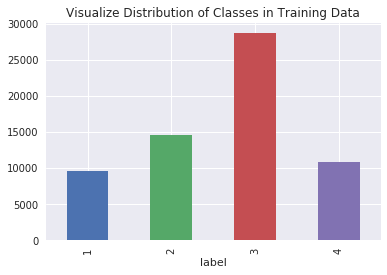

In [0]:
# Visualize distribution of classes
train_df.groupby(['label']).size().plot(title='Visualize Distribution of Classes in Training Data', kind='bar')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


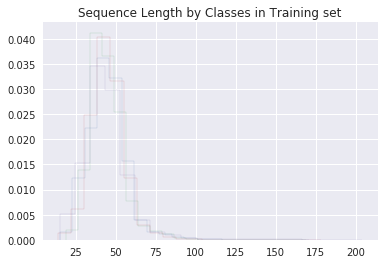

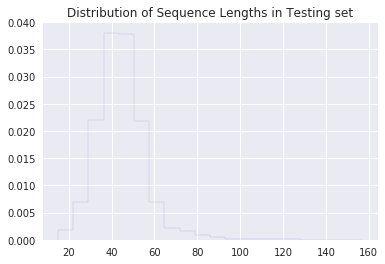

In [0]:
def get_word_sequence_df(input_df):
    """Get new dataframe treating comma separate word tokens as sequences"""
    df_for_viz = input_df.copy()
    df_for_viz['words_in_df'] = input_df['sequence'].str.split(',')
    df_for_viz['sequence_length'] = df_for_viz['words_in_df'].map(len)
    return df_for_viz

# Visualize sequence lengths by classes
visualized_train_df = get_word_sequence_df(train_df)
visualized_test_df = get_word_sequence_df(to_predict_test)
kwaargs = dict(histtype='step', alpha=0.5, normed=True, bins=20, fill=False)
classes_to_predict = np.sort(visualized_train_df['label'].unique())
for label_value in classes_to_predict:
    plt.hist(visualized_train_df['sequence_length'][visualized_train_df['label']==label_value].values, **kwaargs)
    plt.title('Sequence Length by Classes in Training set')
plt.show()

# Visualize sequence lengths in test data
plt.hist(visualized_test_df['sequence_length'].values, **kwaargs)
plt.title('Distribution of Sequence Lengths in Testing set')
plt.show()

In [0]:
# Bin sequence lengths by classes to better understand distribution in Training data
bins = [50, 100, 150, 250]
print('sequence lengths in Training data by classes:')
visualized_train_df.groupby(['label', pd.cut(visualized_train_df['sequence_length'], bins)]).size().unstack()

sequence lengths in Training data by classes:


sequence_length,"(50, 100]","(100, 150]","(150, 250]"
label,,,
1,2618,19,2
2,3436,24,3
3,7146,32,5
4,2552,86,25


## Split labelled data into training and validation data set.

In [0]:
# Tokenize word sequences for training, validation and prediction
all_sequences = train_df['sequence'].values
# Convert word tokens in Sequence to sequence of integers
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(all_sequences)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(all_sequences)
# Set max length based on previously visualized sequence distributions
max_sequence_length = 120
X = sequence.pad_sequences(X, maxlen=max_sequence_length)

# Transform class labels to one-hot encodings
lb = LabelBinarizer()
Y = lb.fit_transform(train_df['label'])

# Split training data into training and validation set
X_training, X_validation, y_training, y_validation = train_test_split(X, Y, test_size=0.2, stratify = Y)

## Build a prediction model from training data and predict on testing data.

In [0]:
def evaluate_sequence_model(X_train, X_val, y_train, y_val):
    """Build and Evaluate CNN based model for classifying word sequences"""
    embedding_dimension = 11
    filter_sizes = (3,5,9,15,21)
    conv_blocks = []
    embedding_layer = Embedding(len(tokenizer.word_index)+1, embedding_dimension, input_length=max_sequence_length)
    callbacks = [EarlyStopping(monitor='val_acc', verbose=1, patience=4)]
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    reshape = Dropout(0.1)(embedded_sequences)
    # Add convolutional layer for each filter size
    for size_val in filter_sizes:
        conv = Conv1D(
          filters=32,
          kernel_size=size_val,
          padding='valid',
          activation='relu',
          strides=1)(reshape)
        conv = MaxPooling1D(pool_size=2)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    merged = Concatenate()(conv_blocks)
    dropout = Dropout(0.25)(merged)
    normalize = BatchNormalization()(dropout)
    output = Dense(256, activation='relu')(normalize)
    normalized_output = BatchNormalization()(output)
    predictions = Dense(4, activation='softmax')(normalized_output)
    model = Model(sequence_input, predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.save_weights('model.h5')
    model.fit(X_train, y_train,  batch_size=64, verbose=0, validation_split=0.15,callbacks=callbacks,epochs=30)
    _, validation_accuracy = model.evaluate(X_val, y_val, verbose = 1)
    return model, validation_accuracy

In [0]:
final_model, final_validation_accuracy = evaluate_sequence_model(X_training, X_validation, y_training, y_validation)

/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 00006: early stopping
12756/12756 [==============================] - 4s 302us/step


training accuracy = 0.9804782438259506
validation accuracy = 0.8947162119786767


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


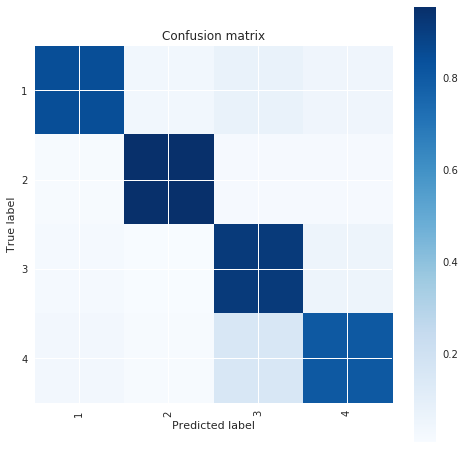

             precision    recall  f1-score   support

          0       0.88      0.84      0.86      1914
          1       0.95      0.95      0.95      2935
          2       0.91      0.92      0.91      5739
          3       0.79      0.80      0.80      2168

avg / total       0.89      0.89      0.89     12756



In [0]:
def show_model_performance(trained_model, training_sequences, validation_sequences, actual_training_labels, actual_validation_labels):
  """Show model performance on validation set, plot confusion matrix and classification report with F1 score"""
  predictions_on_training = trained_model.predict(training_sequences)
  predictions_on_validation_set = trained_model.predict(validation_sequences)
  print('training accuracy = {}'.format(accuracy_score(np.argmax(actual_training_labels, axis=1), 
                                                       np.argmax(predictions_on_training, axis=1))))
  ground_truth_for_validation = np.argmax(actual_validation_labels, axis=1)
  predictions_for_validation = np.argmax(predictions_on_validation_set, axis=1)   
  print('validation accuracy = {}'.format(accuracy_score(ground_truth_for_validation, 
                                              predictions_for_validation)))
  # Plot confusion matrix
  cm = confusion_matrix(ground_truth_for_validation, predictions_for_validation)
  cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  np.set_printoptions(precision=2)
  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes_to_predict))
  plt.xticks(tick_marks, classes_to_predict, rotation=90)
  plt.yticks(tick_marks, classes_to_predict)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print(classification_report(ground_truth_for_validation, predictions_for_validation))

# Show validation accuracy, confusion matrix and classification report
show_model_performance(final_model, X_training, X_validation, y_training, y_validation)

In [0]:
def get_model_predictions(trained_model, sequence_df_to_predict):
  """Get Predictions on Test Data based on trained input model"""
  predict_on_test = tokenizer.texts_to_sequences(sequence_df_to_predict['sequence'].values)
  predict_on_test = sequence.pad_sequences(predict_on_test, maxlen=max_sequence_length)
  return np.argmax(trained_model.predict(predict_on_test), axis=1)

# Get prediction results on test data
to_predict_test['label'] = get_model_predictions(final_model,to_predict_test)
# Append back rows that were already tagged
to_predict_test.append(already_tagged_test)
# reindex based on original raw test data
to_predict_test = to_predict_test.set_index('sequence')
to_predict_test = to_predict_test.reindex(index=test_df['sequence'])
output_df = to_predict_test.reset_index()
# Export final prediction output to tsv
output_df.to_csv('output_sanjayarumugam.tsv', sep = '\t')

NameError: ignored

## Comments


In the initial training data, we saw imbalance between the different classes. 
> The f1-score is thus a good metric to evaluate model performance on this classification task.

The current model scored the highest f1-score on predicting for class 2. 
We also gather that instances of misclassifications are mostly between classes 1,3 and 4. 

To maximize f1-score across different classes, we can:
1. Use hyperparameter optimization to tweak parameters like: embedding dimensions and batch size. 
2. During EDA, there were no word tokens found common across different classes that could be assumed and dropped as stopwords. 
   However, word tokens common between pairs of classes can be dropped and model evaluation can be repeated to compare performance. 
3. The current representation of word tokens is a sequence of integers. A better representation of embeddings would be more contextually aware to represent the semantic differences between different classes. Pretraining embeddings from the training data based on different classes can help improve on the results. 
4. Implement K-fold cross validation on model training and evaluation. 